In [60]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from typing import List, Dict, Any, Optional
import pandas as pd
import openflash
print(type(openflash))
print(openflash.__path__)
print(openflash.__file__)


# --- Import core modules from package ---
try:
    from openflash import *
    from openflash.multi_equations import *
    from openflash.multi_constants import g
    print("OpenFLASH modules imported successfully!")
except ImportError as e:
    print(f"Error importing OpenFLASH modules. Error: {e}")

# Set NumPy print options for better readability
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_constants import rho #need for BEM
from capytaine_generator import CapytaineSlantSolver

# Now you can import from the folder structure
# Assuming 'pyplotutilities' is a folder inside 'sea-lab-utils'
import sys
from pathlib import Path
HERE = Path.cwd().resolve()
utils_path = (HERE / ".." / "sea-lab-utils").resolve()
utils_str = str(utils_path)
if utils_str not in sys.path:
    sys.path.insert(0, utils_str)
from pyplotutilities import colors
colors.get_colors()
print(colors.purple)

figs_path_prefix = str((HERE / ".." / "pubs/JFM/figs").resolve())
store_path_prefix = str((HERE / "data").resolve())
store_path_str = store_path_prefix + "/slants.pkl"

<class 'module'>
['/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash']
/Users/Bimali/Desktop/SEALab/OpenFLASH/package/src/openflash/__init__.py
OpenFLASH modules imported successfully!
#CC79A7


In [61]:
# Variable definitions and data loading
h = 50.00 # sea depth [m]
omega_sweep = np.linspace(0.4, 1.5, 10) # rad/s
omega_fixed = 1

d_in_1 = [14.45, 14.45-7.32] # drafts [m]
d_out_1 = [14.45, 14.45-7.32-5.08] # non-slanted version
a_list_1 = [2.5/2, 8.4/2] # radii [m]
NMK_1 = [200, 200, 200] # number of coefficients in each region

d_in_2 = [14.45]
d_out_2 = [0]
a_list_2 = [8.4/2]
NMK_2 = [200, 200]

d_in_3 = [1.26]
d_out_3 = [0]
a_list_3 = [8.4/2]
NMK_3 = [200, 200]

d_in_4 = [40]
d_out_4 = [1e-4]
a_list_4 = [8.4/2]
NMK_4 = [200, 200]

config_geoms = {"Config 1" : {"d_in" : d_in_1, "d_out" : d_out_1, "a_list" : a_list_1, "NMK" : NMK_1},
                "Config 2" : {"d_in" : d_in_2, "d_out" : d_out_2, "a_list" : a_list_2, "NMK" : NMK_2},
                "Config 3" : {"d_in" : d_in_3, "d_out" : d_out_3, "a_list" : a_list_3, "NMK" : NMK_3},
                "Config 4" : {"d_in" : d_in_4, "d_out" : d_out_4, "a_list" : a_list_4, "NMK" : NMK_4}}

res_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]

with open(store_path_str, 'rb') as file:
    data = pickle.load(file)

In [62]:
# Plot Settings
l_width = 3 # line width
m_size = 7 # marker size
lab_fs = 11 # x and y label font size
leg_fs = lab_fs * 0.8  # legend font size
fig_h = 9 # figure height
fig_w = 4 # figure width

In [63]:
css = CapytaineSlantSolver(False, False, False, False, False)

# Function for getting coordinates of WEC geometry
def get_scaled_geom(a_list, d_in, d_out):

    RHS_coords = css.get_points(a_list, d_in, d_out)
    x_coords, y_coords = map(np.array, zip(*RHS_coords))

    x_undeformed = np.concatenate([-x_coords[::-1], x_coords])
    y_undeformed = np.concatenate([y_coords[::-1], y_coords])

    
    return x_undeformed, y_undeformed

def plot_geom(ax, a_list, d_in, d_out):
  x_undeformed, y_undeformed = get_scaled_geom(a_list, d_in, d_out)
  x0, x_width = 0.82, 0.16
  y_height = max(d_in)/(2 * a_list[-1]) * x_width
  y0 = 0.97 - y_height
  ax_ins = ax.inset_axes([x0, y0, x_width, y_height])
  ax_ins.fill(x_undeformed, y_undeformed, color=[0.7,0.7,0.7], edgecolor='black')
  ax_ins.set_aspect('equal')
  ax_ins.set_xticks([])
  ax_ins.set_yticks([])
  ax_ins.axis('off') 


In [64]:
def plot_type_1_subplot(data, omega_sweep, hydro_key, ax):
  cpt_data = data["Config 1 Sweep"]["CPT " + hydro_key]
  meem_data = data["Config 1 Sweep"]["MEEM " + hydro_key]
  mod_meem_data = data["Config 1 Sweep"]["Modified MEEM " + hydro_key]

  ax.plot(omega_sweep, meem_data.squeeze(), marker='o', 
           linestyle='-', color=colors.blue, label='MEEM', 
           linewidth=l_width-1.5, markersize=m_size-3, zorder=4)
  ax.plot(omega_sweep, mod_meem_data.squeeze(), marker='s', 
           linestyle='-', color=colors.skyblue, label='Corrected MEEM', 
           linewidth=l_width-1, markersize=m_size-1, zorder=3)
  ax.plot(omega_sweep, cpt_data.squeeze(), marker='D',
           linestyle='-', color=colors.orange, label='Capytaine', 
           linewidth=l_width, markersize=m_size, zorder=2)
  ax.fill_between(omega_sweep, (cpt_data.squeeze()) * 0.95, (cpt_data.squeeze()) * 1.05,
                  alpha=0.2, color = colors.green,
                  linewidth=0, label = "Within 5% of Capytaine", zorder=1)
  
  ax.set_xlim([min(omega_sweep), max(omega_sweep)])

def plot_type_1(data, omega_sweep, ax1, ax2):
  plot_type_1_subplot(data, omega_sweep, "Added Mass", ax1)
  plot_geom(ax1, a_list_1, d_in_1, d_out_1)

  ax1.set_ylabel('Added Mass [kg]', fontsize=lab_fs)

  plot_type_1_subplot(data, omega_sweep, "Damping", ax2)
  ax2.set_ylabel('Damping [Ns/m]', fontsize=lab_fs)

def plot_type_2_subplot(data, res_lst, idx, hydro_key, ax):
  cf_name = "Config " + str(idx)
  cpt_data = data[cf_name]["CPT " + hydro_key]
  meem_data = [data[cf_name]["MEEM " + hydro_key][res] for res in res_lst]
  mod_meem_data = [data[cf_name]["Modified MEEM " + hydro_key][res] for res in res_lst]

  ax.plot(res_lst, meem_data, marker='o', 
           linestyle='-', color=colors.blue, label='MEEM', 
           linewidth=l_width-1.5, markersize=m_size-3, zorder=4)
  ax.plot(res_lst, mod_meem_data, marker='s', 
          linestyle='-', color=colors.skyblue, label='MEEM with Correction', 
          linewidth=l_width-1, markersize=m_size-1, zorder=3)
  ax.axhline(y = cpt_data, linestyle='-', color=colors.orange, label='Capytaine', 
             linewidth=l_width, zorder=2)
  ax.axhspan(0.95 * cpt_data, 1.05 * cpt_data, alpha=0.2, color = colors.green,
            linewidth=0, label = "Within 5% of Capytaine", zorder=1)
  ax.set_xlim([0, max(res_lst)])
  
def plot_type_2(data, res_lst, idx, ax1, ax2):
  plot_type_2_subplot(data, res_lst, idx, "Added Mass", ax1)
  ax1.set_ylabel('Added Mass [kg]', fontsize=lab_fs)

  cf_name = "Config " + str(idx)
  plot_geom(ax1, config_geoms[cf_name]["a_list"],
            config_geoms[cf_name]["d_in"],
            config_geoms[cf_name]["d_out"])
  
  plot_type_2_subplot(data, res_lst, idx, "Damping", ax2)
  ax2.set_ylabel('Damping [Ns/m]', fontsize=lab_fs)


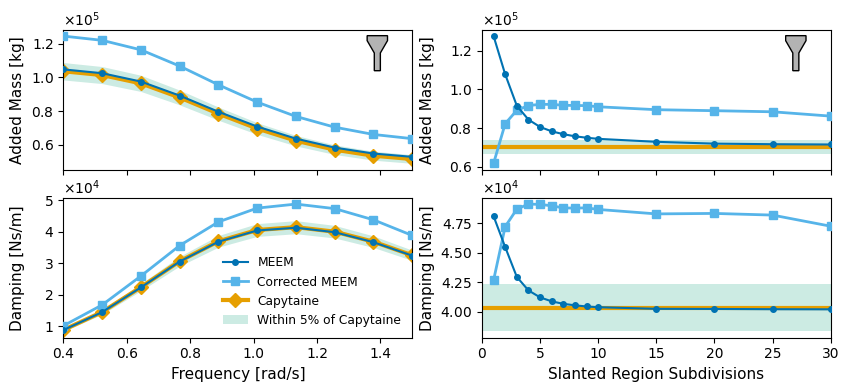

In [65]:
fig, ax = plt.subplots(2, 2, figsize=(fig_h * 1.1, fig_w), sharex='col')
for a in ax.flat:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

plot_type_1(data, omega_sweep, ax[0,0], ax[1,0])
plot_type_2(data, res_lst, 1, ax[0,1], ax[1,1])
ax[1,1].set_xlabel('Slanted Region Subdivisions', fontsize=lab_fs)
ax[1,0].set_xlabel('Frequency [rad/s]', fontsize=lab_fs)
ax[1,0].legend(loc='lower right', fontsize=leg_fs, frameon=False)
fig.align_ylabels()

full_path = figs_path_prefix + "/MEEM-CPT-Slant-Freq.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')

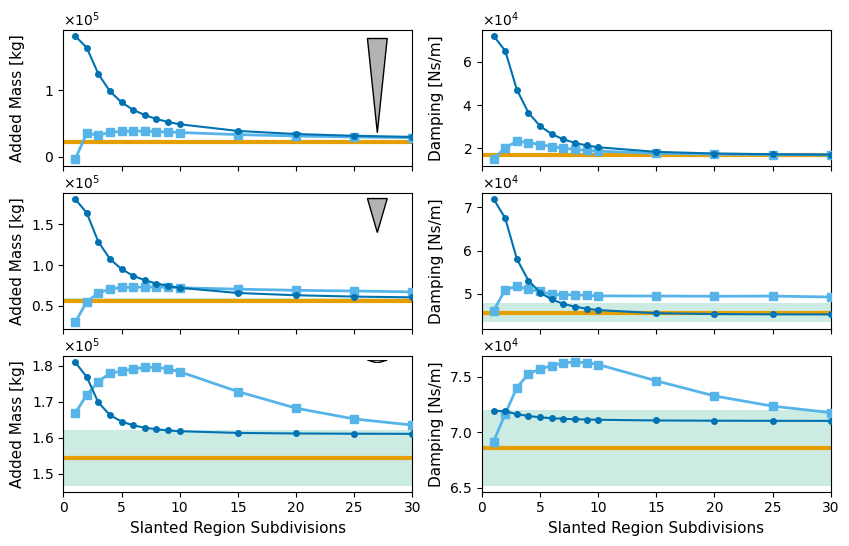

In [66]:
fig, ax = plt.subplots(3, 2, figsize=(fig_h * 1.1, fig_w * 1.5), sharex='col')
for a in ax.flat:
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1)) 
    a.yaxis.set_major_formatter(formatter)

plot_type_2(data, res_lst, 2, ax[1,0], ax[1,1])
plot_type_2(data, res_lst, 3, ax[2,0], ax[2,1])
plot_type_2(data, res_lst, 4, ax[0,0], ax[0,1])
ax[2,0].set_xlabel('Slanted Region Subdivisions', fontsize=lab_fs)
ax[2,1].set_xlabel('Slanted Region Subdivisions', fontsize=lab_fs)
fig.align_ylabels()
full_path = figs_path_prefix + "/MEEM-CPT-Slant-Subdivisions.pdf"
fig.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight')